## Imports

In [1]:
pip install pyccel

     |████████████████████████████████| 350 kB 4.7 MB/s 
     |████████████████████████████████| 74 kB 1.8 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 


In [3]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time

#fill the libraries import
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [30]:
def solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for n in range(nt):
        for i in range (row):
            for j in range(col):
                un[i,j] = u[i,j]
                vn[i,j] = v[i,j]
        for i in range(1, row-1):
            for j in range(1,col-1):
                u[i,j] = un[i,j] - (un[i,j] *( dt / dx) * (un[i,j] - un[i-1,j])) - (vn[i,j] * (dt / dy) * (un[i,j] - un[i,j-1]))
                v[i,j] = vn[i,j] - (un[i,j] * (dt / dx) * (vn[i,j] - vn[i-1,j])) -( vn[i,j] * (dt / dy) * (vn[i,j] - vn[i,j-1]))
                

        
    return 0

## Numba accelerator

In [22]:
#add the numba decorator to accelerate code
@njit(fastmath=True)
def solve_2d_nonlinearconv_numba(u, un, v, vn, nt, dt, dx, dy):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for n in range(nt):
        for i in range (row):
            for j in range(col):
                un[i,j] = u[i,j]
                vn[i,j] = v[i,j]
        for i in range(1, row-1):
            for j in range(1,col-1):
                u[i,j] = un[i,j] - un[i,j] *( dt / dx) * (un[i,j] - un[i-1,j])- vn[i,j] * (dt / dy) * (un[i,j] - un[i,j-1])
                v[i,j] = vn[i,j] - un[i,j] * (dt / dx) * (vn[i,j] - vn[i-1,j])- vn[i,j] * (dt / dy) * (vn[i,j] - vn[i,j-1])
                
        
    return 0

## Pyccel accelerator

In [23]:
def solve_2d_nonlinearconv_pyccel(u:'float[:,:]', un:'float[:,:]',v:'float[:,:]', vn:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float'):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for n in range(nt):
        for i in range (row):
            for j in range(col):
                un[i,j] = u[i,j]
                vn[i,j] = v[i,j]
        for i in range(1, row-1):
            for j in range(1,col-1):
                u[i,j] = un[i,j] - un[i,j] *( dt / dx) * (un[i,j] - un[i-1,j])- vn[i,j] * (dt / dy) * (un[i,j] - un[i,j-1])
                v[i,j] = vn[i,j] - un[i,j] * (dt / dx) * (vn[i,j] - vn[i-1,j])- vn[i,j] * (dt / dy) * (vn[i,j] - vn[i,j-1])
                
        
    return 0

## Inputs

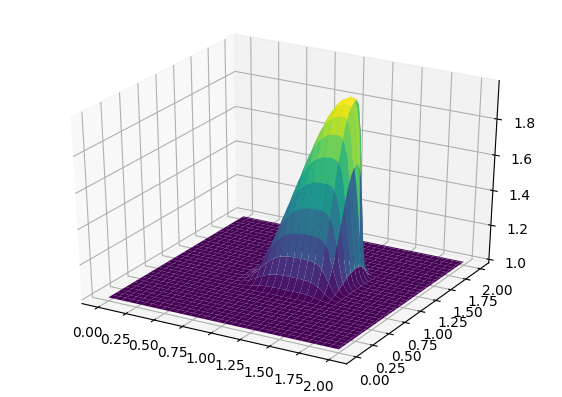

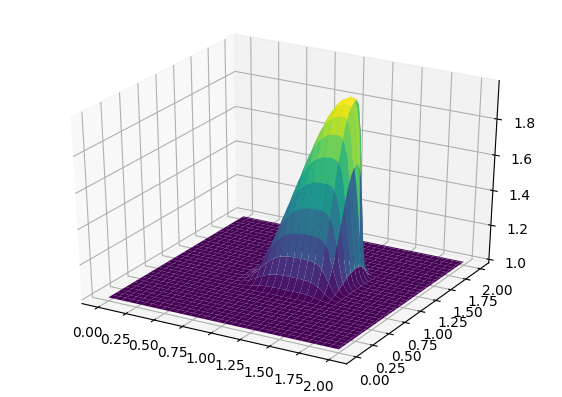

In [31]:
###variable declarations
nx = 101
ny = 101
nt = 80
#c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx)) ##create a 1xn vector of 1's
v = np.ones((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))     

solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)


fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, v, cmap=cm.viridis)

## Call Funtions

### Pure function

In [25]:
%timeit solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy)

1 loop, best of 5: 3.49 s per loop


### Function with numba accelerator

In [27]:
%timeit solve_2d_nonlinearconv_numba(u, un, v, vn, nt, dt, dx, dy)

The slowest run took 144.28 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 4.2 ms per loop


### Function with pyccel accelerator

In [28]:
solve_2d_nonlinearconv_f90 = epyccel(solve_2d_nonlinearconv_pyccel)

In [29]:
%timeit solve_2d_nonlinearconv_f90(u, un, v, vn, nt, dt, dx, dy)

100 loops, best of 5: 3.48 ms per loop
